In [1]:
%matplotlib inline

# Fill air temperature and Ug
Explores filling methods for 2 m air temperature and gauge height wind speed for NP drifting station data

In [2]:
import sys
sys.path.append('../source')

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import readers.npsnow as npsnow
from merge_npsnow_data import get_station_list, merge_one_station
from constants import DATADIR

## Merge data for all stations beyond NP-4 and excluding NP-14

In [67]:
def load_station(sid):
    df = merge_one_station(sid, set_noprecip=False).reset_index().rename({'index': 'Date'}, axis=1)
    df['Ptrace'] = np.where((df['PRECIP'] == 0.) & (df['PTYPE'] > 0.), 0.1, 0.)  # Set trace precipitation were PRECIP == 0
    df['PRECIP'] = df['PRECIP'].where(df['PRECIP'] > 0., 0.)
    df['PTYPE'] = df['PTYPE'].where(df['PTYPE'] > 0., 0.)
    return df
    
df = pd.concat([load_station(statid) for statid in get_station_list() if statid not in ['01','02','03','04','14']])
df = df.reset_index().drop('index', axis=1)

In [68]:
df.head()

,Date,Station_ID,Latitude,Longitude,TAIR,RH,SLP,WDIR,WSPD,TOTCLD,LOWCLD,TSURF,TMIN,TMAX,PRECIP,PTYPE,SDEPTH,Ug,Ptrace
0,1955-05-01,5.0,82.188250,154.748875,-16.3250,NaN,1038.3250,197.5,1.625,8.375000,6.250000,NaN,-18.6,-14.9,0.0,0.0,0.0,1.246391,0.0
1,1955-05-02,5.0,82.188000,154.831250,-16.9250,NaN,1038.2875,62.5,0.250,7.571429,2.000000,NaN,-22.0,-13.6,0.0,0.0,0.0,0.191752,0.0
2,1955-05-03,5.0,82.189750,154.880875,-19.7125,NaN,1034.0250,115.0,1.375,8.428571,6.428571,NaN,-21.7,-18.3,0.0,0.0,0.0,1.054639,0.0
3,1955-05-04,5.0,82.203125,154.894375,-18.6125,NaN,1028.8250,147.5,2.375,10.000000,5.000000,NaN,-21.1,-17.3,0.0,0.0,0.0,1.821649,0.0
4,1955-05-05,5.0,82.246000,155.002000,-18.2500,NaN,1023.0750,177.5,4.250,5.333333,5.142857,NaN,-21.0,-17.2,0.0,0.0,0.0,3.259792,0.0


In [69]:
missing = df.WSPD.isna()
#df[missing]

## Distribution of wind speed

Here I look at the distribution of wind speed for the data set as a whole, and also by month, stratifying by wet and dry days.  The assumption is that precipitation days may have higher wind speeds because recipitation is asscoiated with storms.

Of note, is that the modal wind speed is close to or greater than the 6 m/s threshold imposed in the WMO correction. 

Text(0.5, 1.0, 'PRECIP == 0.')

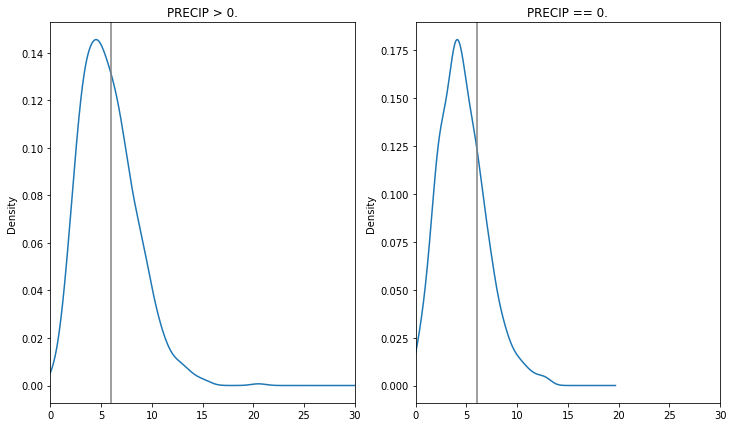

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12,7))
df.loc[df.PRECIP > 0, 'WSPD'].plot(kind='kde', ax=ax[0], xlim=(0,30))
ax[0].axvline(6., color='0.5')
ax[0].set_title('PRECIP > 0.')
df.loc[df.PRECIP <= 0, 'WSPD'].plot(kind='kde', ax=ax[1], xlim=(0,30))
ax[1].axvline(6., color='0.5')
ax[1].set_title('PRECIP == 0.')

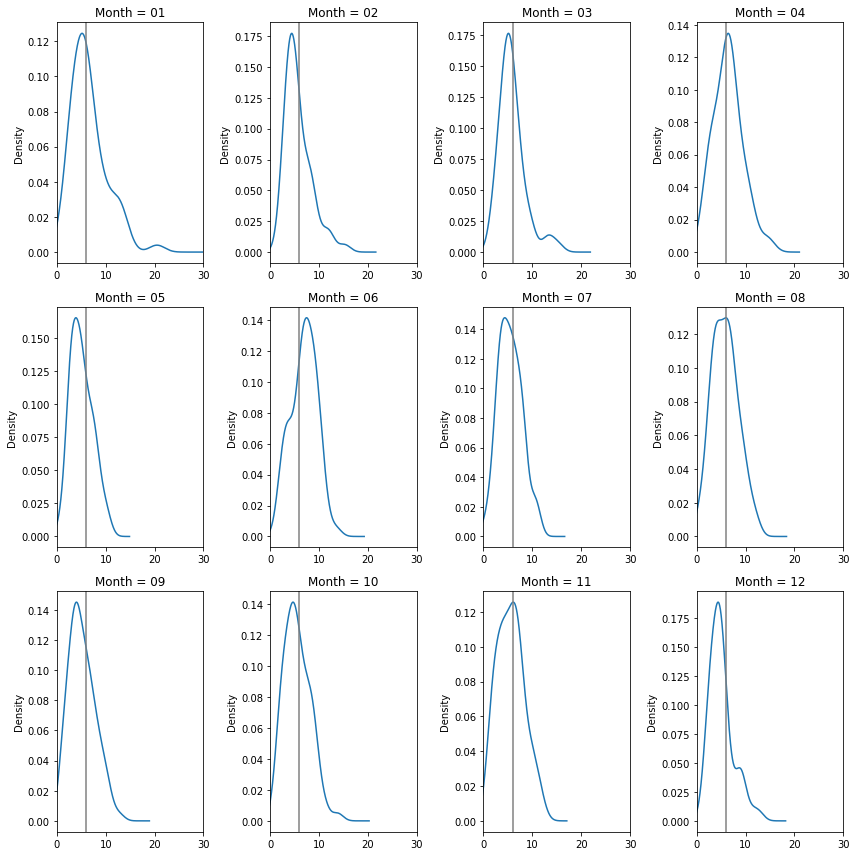

In [59]:
fig, ax = plt.subplots(3, 4, figsize=(12, 12))
for m, ix in zip(range(1,13), ax.flatten()):
    df.loc[(df.PRECIP > 0) & (df.Date.dt.month == m), 'WSPD'].plot(kind='kde', ax=ix, xlim=(0,30))
    ix.axvline(6., color='0.5')
    ix.set_title(f'Month = {m:02d}')
    
plt.tight_layout()

## Fill missing values with monthly mean wind speed and air temperature for days with precipitation

This is a simple approach.  An alternative might be to develop a regression relationship between SLP and wind but in many cases, SLP is also missing

In [64]:
monAvg_wet = df[df.PRECIP > 0].groupby(df.Date.dt.month).mean()[['WSPD', 'TAIR']]
for m, wspd, tair in zip(range(1,13), monAvg_wet.WSPD.values, monAvg_wet.TAIR.values):
    df.loc[(df.Date.dt.month == m) & (df.WSPD.isna()), 'WSPD'] = wspd
    df.loc[(df.Date.dt.month == m) & (df.TAIR.isna()), 'TAIR'] = tair
